**Autor: Mariana Chaves**
 
**Date: August 2022**

In this notebook we train ProtoryNet models of 10, 30 and 50 prototypes to classify movie characters according to their gender based on their dialogues. 
First, we train them using classic train, validation, test split. 
Later we train them using **leave-some-movies-out** cross-validation. 
We present their accuracy results, in both cases the model with 10 prototypes performs the best. 
We take a few samples from the testing set and use the best model to see the prototypes associated to each of their sentences. 
This analysis should provide some explainability of the results, nevertheless the relationship between each sentences and its active prototype is very hard to understand which leads to basically no interpretability.  

# Setup

Install the following commented packages if required.

In [2]:
# !pip install -q pyyaml h5py

In [1]:
# !pip install scikit-learn-extra

In [280]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sys
import time
import myfunctions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sys.path.append('../src/protoryNet/')
from protoryNet import ProtoryNet

In [ ]:
# Go to main directory
%cd ..

c:\Users\Dell\Documents\UCA DSAI\Internship 2\Code\text-models


In [ ]:
results_path = 'results/protorynet_models/'

In [288]:
# Path for saving images
# Make sure to change this to your own path!!!
path_of_saving_images = '//wsl$/Ubuntu-20.04/home/mchaves/internship2/final_report/internship_report/img/'

# Load data

To see how these datasets were created see the ```protorynet_prototype_initializations.ipynb``` notebook. 

Note that we load only train and test set, and not the validation set. 
That is because for the results we explore in this notebook we need the training set for the projection of the prototypes, and the test set of evaluating results on test. 
Nevertheless, the validation set is used in ```train_protorynet.py```. 

In [7]:
# Loading the train and testing splits

directory =  'datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/'

x_train = pickle.load(open(directory + 'x_train', 'rb'))
x_test = pickle.load(open(directory + 'x_test', 'rb'))
y_train = pickle.load(open(directory + 'y_train', 'rb'))
y_test = pickle.load(open(directory + 'y_test', 'rb'))

# Functions

In [5]:
def score_trajectory(protorynet_model, list_of_sentences):
    '''
    Given a list of sentences (usually a list of prototypes), it returns the prediction for each of them. 
    Inputs:
    protorynet_model: a protorynet model
    list_of_sentences: a list of sentences
    '''
    pred = []
    for prot in list_of_sentences:
        pred.append(protorynet_model.predict([prot])[0])
    return pred

In [8]:
def eval_protorynet_after_training(x_train, y_train, x_test, y_test, model_directory, model_name, results_path): 
    
    '''
    This function takes a trained protorynet model and computes the train and evaluation accuracy, final prototypes, their predictions scores. 
    It returns the results and saves them in a pickle file. 
    Inputs:
        x_train: list of texts that belong to the train set. Each element of the list can contain many sentences.
        y_train: binary target variables of the train set
        x_test: ist of texts that belong to the test set. Each element of the list can contain many sentences.
        y_test: binary target variables of the test set
        model_directory: directory where the model was saved
        model_name: name of the model. Without '.h5' at the end
        results_path: directory to save the results
    '''

    # --------------------------
    # Data preprocessing
    # --------------------------

    # Guarantee target variable is integer
    y_train = [int(y) for y in y_train]
    y_test = [int(y) for y in y_test]

    # Split text into lists of sentences 
    x_train = myfunctions.split_sentences(x_train)
    x_test = myfunctions.split_sentences(x_test)

    # Make a list of sentences (only for training set)
    train_sentences = []
    for p in x_train:
        train_sentences.extend(p)

    # We remove very short or very long sentences since they behave as outliers.
    train_sentences = [i for i in train_sentences if len(i)>5 and len(i)<100]

    # --------------------------
    # Load model and it's results
    # --------------------------

    model_path = model_directory + model_name

    # Number of prototypes
    try: 
        # Extract it from information derived from training
        train_info = pickle.load(open(model_path + '.pickle', 'rb'))
        number_prototypes = train_info['args'].number_prototypes
    except: 
        # Extract number of prototypes from models name
        number_prototypes = int(re.search('[0-9]*prototypes', model_name).group(0).replace('prototypes',''))

    # Load model
    pNet_saved = ProtoryNet()
    model = pNet_saved.createModel(np.zeros((number_prototypes, 512)), number_prototypes)
    model.load_weights(model_path + '.h5')

    # Sentence embedding using the finetune embedder in the model
    
    start = time.time()
    train_sentences_embedded = pNet_saved.embed(train_sentences)
    print('Embedding time (minutes):', (time.time() - start) / 60)

    # --------------------------
    # Evaluate
    # --------------------------

    # Evaluate the model on training and testing data
    start = time.time()
    preds_train, accuracy_train = pNet_saved.evaluate(x_train, y_train)
    preds_test, accuracy_test = pNet_saved.evaluate(x_test, y_test)
    print('Evaluation time (minutes):', (time.time() - start) / 60)

    # --------------------------
    # Final prototypes
    # --------------------------
    start = time.time()

    # Final_prototypes
    final_prototypes = pNet_saved.showPrototypes(train_sentences, train_sentences_embedded, number_prototypes, printOutput=False, return_prototypes = True)

    # Prediction score of prototypes
    final_prototypes_pred_scores = score_trajectory(pNet_saved, list(final_prototypes.values()))

    print('Prototypes time (minutes):', (time.time() - start) / 60)
    # --------------------------
    # Save and return results
    # --------------------------    

    # Save and return results
    results = {'accuracy_train': accuracy_train,
              'accuracy_test': accuracy_test,
              'predictions_on_test': preds_test,
              'final_prototypes': final_prototypes,
              'final_prototypes_pred_scores': final_prototypes_pred_scores
              }

    pickle.dump(results, open(results_path + 'eval' + model_name + '.pickle', 'wb'))
    return results 

In [36]:
def eval_examples(list_of_examples_text, x_train, model_directory, model_name, results_path):
    
    '''
    This function takes a trained protorynet model and a list of texts and computes the protorynet predictions for such texts, along with the prototypes associated to each sentence each text. 
    It returns the results and saves them in a pickle file. 
    Inputs:
        list_of_examples_text: a list of strings. Each string can contain several sentences.
        x_train: list of texts that belong to the train set. Each element of the list can contain many sentences.
        model_directory: directory where the model was saved
        model_name: name of the model. Without '.h5' at the end
        results_path: directory to save the results
    '''

    # --------------------------
    # Data preprocessing
    # --------------------------

    # Split text into lists of sentences 
    x_train = myfunctions.split_sentences(x_train)
    list_of_examples_text = myfunctions.split_sentences(list_of_examples_text)

    # Make a list of sentences (only for training set)
    train_sentences = []
    for p in x_train:
        train_sentences.extend(p)

    # We remove very short or very long sentences since they behave as outliers.
    train_sentences = [i for i in train_sentences if len(i)>5 and len(i)<100]

    # --------------------------
    # Load model and it's results
    # --------------------------

    model_path = model_directory + model_name

    # Number of prototypes
    try: 
        # Extract it from information derived from training
        train_info = pickle.load(open(model_path + '.pickle', 'rb'))
        number_prototypes = train_info['args'].number_prototypes
    except: 
        # Extract number of prototypes from models name
        number_prototypes = int(re.search('[0-9]*prototypes', model_name).group(0).replace('prototypes',''))


    # Load model
    pNet_saved = ProtoryNet()
    model = pNet_saved.createModel(np.zeros((number_prototypes, 512)), number_prototypes)
    model.load_weights(model_path + '.h5')

    start = time.time()
    # Sentence embedding using the finetune embedder in the model
    train_sentences_embedded = pNet_saved.embed(train_sentences)
    print('Embedding time (minutes):', (time.time() - start) / 60)
    
    # --------------------------
    # Final prototypes
    # --------------------------

    start = time.time()
    
    # Final_prototypes
    final_prototypes = pNet_saved.showPrototypes(train_sentences, train_sentences_embedded, number_prototypes, printOutput=False, return_prototypes = True)

    # Prediction score of prototypes
    final_prototypes_pred_scores = score_trajectory(pNet_saved, list(final_prototypes.values()))
    
    print('Prototypes time (minutes):', (time.time() - start) / 60)

    # --------------------------
    # Predictions and prototypes for specific examples
    # --------------------------
    start = time.time()
    
    preds = []
    prototypes_matching = []
    prototypes_matching_pred_scores = []

    for example in list_of_examples_text:
        preds.append(pNet_saved.predict(example)[0])
        matched_prototypes = pNet_saved.showTrajectory(example, train_sentences, train_sentences_embedded, number_prototypes)
        prototypes_matching.append(matched_prototypes)
        prototypes_matching_pred_scores.append(score_trajectory(pNet_saved, matched_prototypes))

    print('Preds and prototypes for sentences time (minutes):', (time.time() - start) / 60)
    
    # --------------------------
    # Save and return results
    # -------------------------- 

    results = {'predictions': preds,
               'prototypes_matching': prototypes_matching,
               'prototypes_matching_pred_scores': prototypes_matching_pred_scores}

    pickle.dump(results, open(results_path + 'eval_ex' + model_name + '.pickle', 'wb'))
    return results

# Train models

To train the models we use ```train_protorynet.py```. Check the file for all specifications about its arguments. 

We consider models of 10, 30 and 50 prototypes using random initialization of the prototypes. 
Since we could start with a "bad initialization", we repeat the training 3 times, each time we change the seed that determines the random sampling of the initial prototypes.

These are the commands to train the models: 

Model with 10 prototypes: 

```
python scripts_and_notebooks/train_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/ --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters_70train_20val_10test --epochs=20 --number_prototypes=10 --type_init=random --sample_size_sentences=30000 --init_prototypes_seed=16
python scripts_and_notebooks/train_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/ --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters_70train_20val_10test --epochs=20 --number_prototypes=10 --type_init=random --sample_size_sentences=30000 --init_prototypes_seed=128
python scripts_and_notebooks/train_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/ --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters_70train_20val_10test --epochs=20 --number_prototypes=10 --type_init=random --sample_size_sentences=30000 --init_prototypes_seed=81
```

Model with 30 prototypes: 

``` 
python scripts_and_notebooks/train_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/ --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters_70train_20val_10test --epochs=20 --number_prototypes=30 --type_init=random --sample_size_sentences=30000 --init_prototypes_seed=16;
python scripts_and_notebooks/train_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/ --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters_70train_20val_10test --epochs=20 --number_prototypes=30 --type_init=random --sample_size_sentences=30000 --init_prototypes_seed=81;
python scripts_and_notebooks/train_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/ --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters_70train_20val_10test --epochs=20 --number_prototypes=30 --type_init=random --sample_size_sentences=30000 --init_prototypes_seed=128;
```

Model with 50 prototypes: 

```
python scripts_and_notebooks/train_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/ --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters_70train_20val_10test --epochs=20 --number_prototypes=50 --type_init=random --sample_size_sentences=30000 --init_prototypes_seed=16;
python scripts_and_notebooks/train_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/ --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters_70train_20val_10test --epochs=20 --number_prototypes=50 --type_init=random --sample_size_sentences=30000 --init_prototypes_seed=81;
python scripts_and_notebooks/train_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_70train_20val_10test/ --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters_70train_20val_10test --epochs=20 --number_prototypes=50 --type_init=random --sample_size_sentences=30000 --init_prototypes_seed=128;
```


# Evaluate the models

Once we had the final models, we get their accuracy, the final prototypes among others. 

In [5]:
# Models
models = [
          'cornell_prepro_characters_70train_20val_10test__20epochs__10prototypes__randomtype_init__30000sample_size_sentences__16init_prototypes_seed', 
          'cornell_prepro_characters_70train_20val_10test__20epochs__10prototypes__randomtype_init__30000sample_size_sentences__81init_prototypes_seed', 
          'cornell_prepro_characters_70train_20val_10test__20epochs__10prototypes__randomtype_init__30000sample_size_sentences__128init_prototypes_seed', 
          'cornell_prepro_characters_70train_20val_10test__20epochs__30prototypes__randomtype_init__30000sample_size_sentences__16init_prototypes_seed',
          'cornell_prepro_characters_70train_20val_10test__20epochs__30prototypes__randomtype_init__30000sample_size_sentences__81init_prototypes_seed',
          'cornell_prepro_characters_70train_20val_10test__20epochs__30prototypes__randomtype_init__30000sample_size_sentences__128init_prototypes_seed',
          'cornell_prepro_characters_70train_20val_10test__20epochs__50prototypes__randomtype_init__30000sample_size_sentences__16init_prototypes_seed',
          'cornell_prepro_characters_70train_20val_10test__20epochs__50prototypes__randomtype_init__30000sample_size_sentences__81init_prototypes_seed',
          'cornell_prepro_characters_70train_20val_10test__20epochs__50prototypes__randomtype_init__30000sample_size_sentences__128init_prototypes_seed',
         ]

# Define some short name for each model. For readability.
models_short_name = ['10 prototypes model 1', '10 prototypes model 2', '10 prototypes model 3',
                    '30 prototypes model 1', '30 prototypes model 2', '30 prototypes model 3',
                    '50 prototypes model 1', '50 prototypes model 2', '50 prototypes model 3']


In [10]:
# Evaluate models after training

# Get train and test validation accuaracy, final prototypes, among others...
for model_name in models:
    results = eval_protorynet_after_training(x_train, y_train, x_test, y_test, 
                                   model_directory = 'results/protorynet_models/',
                                   model_name = model_name, 
                                   results_path= 'results/protorynet_models/')

[db] model.input =  KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.string, name='input_4'), name='input_4', description="created by layer 'input_4'")
[db] protoLayerName =  proto_layer
[db] protoLayer =  <protoryNet.ProtoryNet.createModel.<locals>.prototypeLayer object at 0x7fbbe896e850>
[db] protoLayer.output =  (<KerasTensor: shape=(1, None, 10) dtype=float32 (created by layer 'proto_layer')>, <KerasTensor: shape=(10, 512) dtype=float32 (created by layer 'proto_layer')>)
[db] distanceLayer.output =  KerasTensor(type_spec=TensorSpec(shape=(1, None, 10), dtype=tf.float32, name=None), name='distance_layer/PartitionedCall:0', description="created by layer 'distance_layer'")
Model: "custom_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_3 (Keras

 lstm_5 (LSTM)               [(1, None, 128),          91648     
                              (1, 128),                          
                              (1, 128)]                          
                                                                 
 tf.__operators__.getitem_5   (1, 128)                 0         
 (SlicingOpLambda)                                               
                                                                 
 dense_5 (Dense)             (1, 1)                    129       
                                                                 
 tf.compat.v1.squeeze_5 (TFO  (1,)                     0         
 pLambda)                                                        
                                                                 
 model_20 (Functional)       ((1, None, 50),           256823424 
                              (50, 512))                         
                                                                 
 model_21 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_8 (KerasLayer)  (None, 512)               256797824 
                                                                 
 tf.expand_dims_8 (TFOpLambd  (1, None, 512)           0         
 a)                                                              
                                                                 
 proto_layer (prototypeLayer  ((1, None, 50),          25600     
 )                            (50, 512))                         
                                                                 
 distance_layer (distanceLay  (1, None, 50)            0         
 er)                                                             
                                                                 
 lstm_8 (L

# Leave-some-movies-out

Leave-one-group-out cross-validation is used. In this case each group is a group of movies. 

The leave-one-group-out code can be found at ```leave-one-group-out_protorynet.py```. Check the file to see how to use the arguments. 

The specific commands for the cross-validation process are:
```
python scripts_and_notebooks/leave-one-group-out_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_LOO.csv --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters --group_variable=movieGroup --text_variable=text_with_punctuation --target_variable=target --epochs=20 --number_prototypes=10 --type_init=random --sample_size_sentences=20000 --init_prototypes_seed=16
python scripts_and_notebooks/leave-one-group-out_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_LOO.csv --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters --group_variable=movieGroup --text_variable=text_with_punctuation --target_variable=target --epochs=20 --number_prototypes=30 --type_init=random --sample_size_sentences=20000 --init_prototypes_seed=16
python scripts_and_notebooks/leave-one-group-out_protorynet.py --dataset_path=datasets/cornell_corpus/cornell_prepro_characters_LOO.csv --results_path=results/protorynet_models/ --results_prefix=cornell_prepro_characters --group_variable=movieGroup --text_variable=text_with_punctuation --target_variable=target --epochs=20 --number_prototypes=50 --type_init=random --sample_size_sentences=20000 --init_prototypes_seed=16
```

# Results

## Results of models trained with classic train-validation-test split.

The models of 10 prototypes consistently show better results than the others. 
Moreover, the more prototypes, the worst the accuracy results. 

In [294]:
# Get results from models

table_of_results = {'Model':[], 'Number of prototypes':[], 'Train accuracy':[], 'Test accuracy':[], 'Men accuracy (on test)':[], 'Women accuracy (on test)':[], 'Training time (hours)':[]}
df_for_metrics_chart = {'Model': [], 'Epochs': [], 'Validation accuracy': [], 'Prototypes':[]}
df_prototypes = {'Model': [], 'Initial Prototypes': [], 'Final Prototypes': [], 'Final Prototypes Score': [], 'Prototypes':[]}
# summarized_table = {'model_name':[], 'test_accuracy':[]} 

for model_name, model_short in zip(models, models_short_name): 

    # Load results
    train_results = pickle.load(open(results_path + model_name + '.pickle', 'rb')) 
    evaluation_results = pickle.load(open(results_path + 'eval' + model_name + '.pickle', 'rb'))
    
    number_prototypes = train_results['args'].number_prototypes    
    predictions_on_test = np.around(evaluation_results['predictions_on_test'],0)

    # Results for table   
    table_of_results['Model'].append(model_short)
    table_of_results['Number of prototypes'].append(number_prototypes)
    table_of_results['Train accuracy'].append(evaluation_results['accuracy_train'] * 100)
    table_of_results['Test accuracy'].append(evaluation_results['accuracy_test'] * 100)
    table_of_results['Men accuracy (on test)'].append(np.mean(predictions_on_test.astype(int)[y_test == 0] == y_test[y_test == 0]) * 100)
    table_of_results['Women accuracy (on test)'].append(np.mean(predictions_on_test.astype(int)[y_test == 1] == y_test[y_test == 1]) * 100)
    table_of_results['Training time (hours)'].append(train_results['train_time']/60)

    # Results for plot 
    epochs = len(train_results['history_validation_accuracy']) 
    df_for_metrics_chart['Model'].extend([model_short] * epochs)
    df_for_metrics_chart['Prototypes'].extend([str(number_prototypes)] * epochs)
    df_for_metrics_chart['Epochs'].extend(list(range(1,epochs+1)))
    df_for_metrics_chart['Validation accuracy'].extend(np.array(train_results['history_validation_accuracy']) * 100)
    
    # Dataset with prototypes
    df_prototypes['Model'].extend([model_short] * number_prototypes)
    df_prototypes['Prototypes'].extend([number_prototypes] * number_prototypes)
    df_prototypes['Initial Prototypes'].extend(list(train_results['initial_prototypes'].values()))
    df_prototypes['Final Prototypes'].extend(list(evaluation_results['final_prototypes'].values()))
    df_prototypes['Final Prototypes Score'].extend(list(evaluation_results['final_prototypes_pred_scores']))

# To pandas dataframes
table_of_results = pd.DataFrame(table_of_results).round(2)
df_for_metrics_chart = pd.DataFrame(df_for_metrics_chart)
df_prototypes = pd.DataFrame(df_prototypes)
df_prototypes.to_csv(results_path + 'df_prototypes.csv')

# Latex table
print(table_of_results.to_latex(index=False))

# Show results
table_of_results


\begin{tabular}{lrrrrrr}
\toprule
                Model &  Number of prototypes &  Train accuracy &  Test accuracy &  Men accuracy (on test) &  Women accuracy (on test) &  Training time (hours) \\
\midrule
10 prototypes model 1 &                    10 &           72.29 &          65.15 &                   65.83 &                     64.46 &                   6.41 \\
10 prototypes model 2 &                    10 &           82.10 &          70.12 &                   80.83 &                     59.50 &                   6.36 \\
10 prototypes model 3 &                    10 &           78.06 &          68.88 &                   75.00 &                     62.81 &                   6.30 \\
30 prototypes model 1 &                    30 &           58.38 &          55.60 &                   59.17 &                     52.07 &                   6.33 \\
30 prototypes model 2 &                    30 &           83.53 &          68.05 &                   74.17 &                     61.98 &      

,Model,Number of prototypes,Train accuracy,Test accuracy,Men accuracy (on test),Women accuracy (on test),Training time (hours)
0,10 prototypes model 1,10,72.29,65.15,65.83,64.46,6.41
1,10 prototypes model 2,10,82.10,70.12,80.83,59.50,6.36
2,10 prototypes model 3,10,78.06,68.88,75.00,62.81,6.30
3,30 prototypes model 1,30,58.38,55.60,59.17,52.07,6.33
4,30 prototypes model 2,30,83.53,68.05,74.17,61.98,6.42
5,30 prototypes model 3,30,78.30,69.29,70.83,67.77,6.32
6,50 prototypes model 1,50,52.20,48.13,88.33,8.26,6.30
7,50 prototypes model 2,50,52.26,53.11,31.67,74.38,6.29
8,50 prototypes model 3,50,57.31,54.77,55.00,54.55,6.28


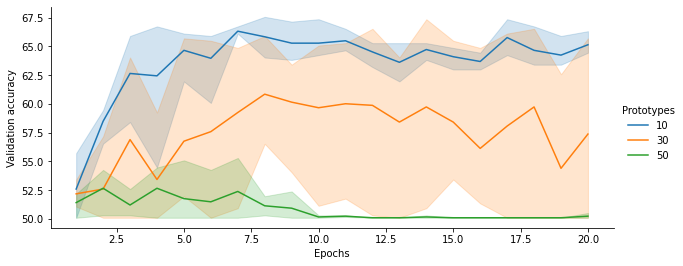

In [296]:
df_for_metrics_chart

fig = sns.relplot(
    data = df_for_metrics_chart, kind = "line",
    x = "Epochs", y = "Validation accuracy", 
    # style = "Model", 
    hue = "Prototypes", 
    height=3.8, aspect = 2.3,
    facet_kws = dict(sharex = True, sharey=False)
)
fig.savefig(path_of_saving_images + 'protorynet_individual_models.png')
fig.savefig(path_of_saving_images + 'protorynet_individual_models.pdf')

# The more prototypes, the worse the accuracy score.
# High variability on the 30 prototypes models

In the table below we see, for instance, that model 1 of 10 prototypes, 40% of the final prototypes are the same as the initial prototypes.

In [81]:
# Check how many prototypes stayed the same
df_prototypes['change'] = df_prototypes['Initial Prototypes'] == df_prototypes['Final Prototypes']
df_prototypes.groupby('Model')[['change', 'Prototypes']].mean()

,change,Prototypes
Model,,
10 prototypes model 1,0.400000,10.0
10 prototypes model 2,0.000000,10.0
10 prototypes model 3,0.400000,10.0
30 prototypes model 1,0.700000,30.0
30 prototypes model 2,0.033333,30.0
30 prototypes model 3,0.433333,30.0
50 prototypes model 1,0.300000,50.0
50 prototypes model 2,0.800000,50.0
50 prototypes model 3,0.000000,50.0


We save a csv with the predictions of each model for the test set samples.
Check them at ```predictions_on_test.csv``` and ```predictions_on_test.xlsx```. 

In [45]:
# Save predictions of each model in a csv file
predictions_on_test = dict()
for model_name, model_short in zip(models, models_short_name): 
    
    train_results = pickle.load(open(results_path + model_name + '.pickle', 'rb')) 
    evaluation_results = pickle.load(open(results_path + 'eval' + model_name + '.pickle', 'rb'))
    predictions_on_test[model_short] = evaluation_results['predictions_on_test']
    
predictions_on_test['ground truth'] = y_test
predictions_on_test['text_with_punctuation'] = x_test

pd.DataFrame(predictions_on_test).to_csv(results_path + 'predictions_on_test.csv')

## Results of models trained with leave-one-group-out

Using **leave-some-movies-out** the models with 10 prototypes remain the best. 

In [284]:
LOGO_files = [
          'leave-one-group-out__20epochs__10prototypes__randomtype_init__20000sample_size_sentences__16init_prototypes_seed', 
          'leave-one-group-out__20epochs__30prototypes__randomtype_init__20000sample_size_sentences__16init_prototypes_seed', 
          'leave-one-group-out__20epochs__50prototypes__randomtype_init__20000sample_size_sentences__16init_prototypes_seed' 
         ]

# Define some short name for each model. For readability.
LOGO_short_name = [
    '10 prototypes',
    '30 prototypes',
    '50 prototypes',
]

# Size of each group
cornell_prepro_characters = pd.read_csv('datasets/cornell_corpus/cornell_prepro_characters.csv')
group_sizes = [i for i in cornell_prepro_characters.groupby('movieGroup').size()]

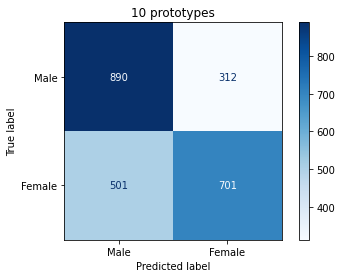

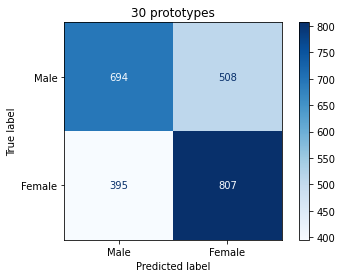

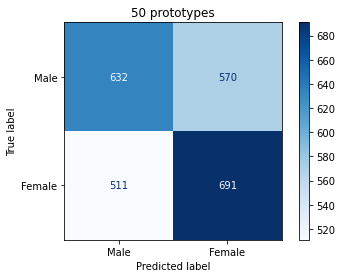

\begin{tabular}{lllll}
\toprule
        Model & Avg. train accuracy ± std & Avg. test accuracy ± std & Avg. men accuracy ± std (on test) & Avg. women accuracy ± std (on test) \\
\midrule
10 prototypes &              90.47 ± 5.36 &             66.18 ± 1.54 &                       74.06 ± 5.3 &                        58.31 ± 4.36 \\
30 prototypes &              80.03 ± 5.37 &             62.51 ± 1.94 &                      58.3 ± 12.19 &                        66.71 ± 9.33 \\
50 prototypes &              53.97 ± 1.72 &             55.02 ± 3.09 &                     52.45 ± 12.97 &                       57.59 ± 12.76 \\
\bottomrule
\end{tabular}



,Model,Avg. train accuracy ± std,Avg. test accuracy ± std,Avg. men accuracy ± std (on test),Avg. women accuracy ± std (on test)
0,10 prototypes,90.47 ± 5.36,66.18 ± 1.54,74.06 ± 5.3,58.31 ± 4.36
1,30 prototypes,80.03 ± 5.37,62.51 ± 1.94,58.3 ± 12.19,66.71 ± 9.33
2,50 prototypes,53.97 ± 1.72,55.02 ± 3.09,52.45 ± 12.97,57.59 ± 12.76


In [286]:
table_of_results = {'Model': [], 'Avg. train accuracy \u00B1 std':[], 'Avg. test accuracy \u00B1 std':[], 'Avg. men accuracy \u00B1 std (on test)':[], 'Avg. women accuracy \u00B1 std (on test)':[]}
df_for_metrics_chart = {'Model': [], 'Epochs': [], 'Validation accuracy': [], 'Group': [], 'Prototypes': []}

for f, name in zip(LOGO_files, LOGO_short_name): 

    # Load results
    results = pickle.load(open(results_path + f + ".pickle", "rb" ))
    
    # Results for table
    table_of_results['Model'].append(name)
    table_of_results['Avg. train accuracy \u00B1 std'].append(str(np.round(np.mean(results['train_accuracy'])*100, 2)) + ' \u00B1 ' + str(np.round(np.std(results['train_accuracy'])*100, 2)))
    table_of_results['Avg. test accuracy \u00B1 std'].append(str(np.round(np.mean(results['test_accuracy'])*100, 2)) + ' \u00B1 ' + str(np.round(np.std(results['test_accuracy'])*100, 2)))
    idx = [0] + list(np.cumsum(group_sizes))

    men_accuracies = []
    women_accuracies = []
    for i in range(len(group_sizes)):
        group_preds = np.round(results['predictions_on_test'][idx[i]:idx[i+1]],0).astype(int)
        group_ground_truth = np.array(results['ground_truth'][idx[i]:idx[i+1]])
        men_accuracy = np.mean(group_ground_truth[group_ground_truth == 0] == group_preds[group_ground_truth == 0])
        women_accuracy = np.mean(group_ground_truth[group_ground_truth == 1] == group_preds[group_ground_truth == 1])
        men_accuracies.append(men_accuracy)
        women_accuracies.append(women_accuracy)    
    table_of_results['Avg. men accuracy \u00B1 std (on test)'].append(str(np.round(np.mean(men_accuracies)*100, 2)) + ' \u00B1 ' + str(np.round(np.std(men_accuracies)*100, 2)))
    table_of_results['Avg. women accuracy \u00B1 std (on test)'].append(str(np.round(np.mean(women_accuracies)*100, 2)) + ' \u00B1 ' + str(np.round(np.std(women_accuracies)*100, 2)))


    # Results for plot 
    groups = len(results['history_validation_accuracy'])
    epochs = len(results['history_validation_accuracy'][0]) 
    df_for_metrics_chart['Model'].extend([name] * epochs * groups)
    df_for_metrics_chart['Prototypes'].extend([str(results['args'].number_prototypes)] * epochs * groups)
    df_for_metrics_chart['Epochs'].extend(list(range(1,epochs+1)) * groups)
    df_for_metrics_chart['Group'].extend(list(np.repeat(range(1, groups + 1), epochs)))
    df_for_metrics_chart['Validation accuracy'].extend(np.array(results['history_validation_accuracy']).flatten())
    
    # # Confusion matrix
    cm = confusion_matrix(y_true = results['ground_truth'], y_pred = np.round(results['predictions_on_test'],0).astype(int))
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
    cmdisp.plot(cmap = 'Blues')
    plt.title(name)
    plt.show()
  
# To pandas dataframes
table_of_results = pd.DataFrame(table_of_results).round(2)
df_for_metrics_chart = pd.DataFrame(df_for_metrics_chart)

# # Latex table
print(table_of_results.to_latex(index=False))

# # Show results
table_of_results


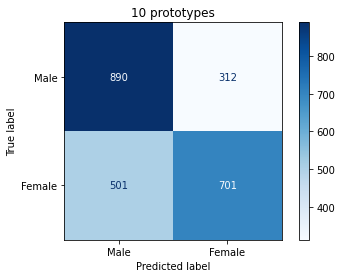

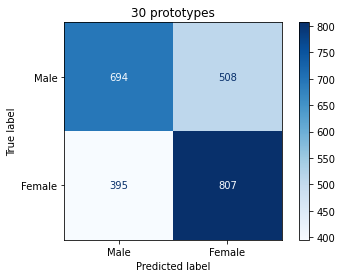

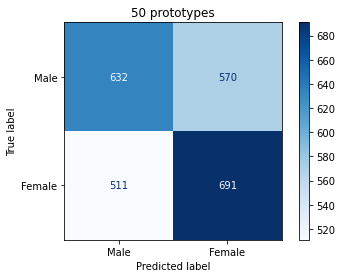

\begin{tabular}{lllll}
\toprule
        Model & Avg. train accuracy ± std & Avg. test accuracy ± std & Avg. men accuracy ± std (on test) & Avg. women accuracy ± std (on test) \\
\midrule
10 prototypes &              90.47 ± 5.36 &             66.18 ± 1.54 &                       74.06 ± 5.3 &                        58.31 ± 4.36 \\
30 prototypes &              80.03 ± 5.37 &             62.51 ± 1.94 &                      58.3 ± 12.19 &                        66.71 ± 9.33 \\
50 prototypes &              53.97 ± 1.72 &             55.02 ± 3.09 &                     52.45 ± 12.97 &                       57.59 ± 12.76 \\
\bottomrule
\end{tabular}



,Model,Avg. train accuracy ± std,Avg. test accuracy ± std,Avg. men accuracy ± std (on test),Avg. women accuracy ± std (on test)
0,10 prototypes,90.47 ± 5.36,66.18 ± 1.54,74.06 ± 5.3,58.31 ± 4.36
1,30 prototypes,80.03 ± 5.37,62.51 ± 1.94,58.3 ± 12.19,66.71 ± 9.33
2,50 prototypes,53.97 ± 1.72,55.02 ± 3.09,52.45 ± 12.97,57.59 ± 12.76


In [298]:
table_of_results = {'Model': [], 'Avg. train accuracy \u00B1 std':[], 'Avg. test accuracy \u00B1 std':[], 'Avg. men accuracy \u00B1 std (on test)':[], 'Avg. women accuracy \u00B1 std (on test)':[]}
df_for_metrics_chart = {'Model': [], 'Epochs': [], 'Validation accuracy': [], 'Group': [], 'Prototypes': []}

for f, name in zip(LOGO_files, LOGO_short_name): 

    # Load results
    results = pickle.load(open(results_path + f + ".pickle", "rb" ))
    
    # Results for table
    table_of_results['Model'].append(name)
    table_of_results['Avg. train accuracy \u00B1 std'].append(str(np.round(np.mean(results['train_accuracy'])*100, 2)) + ' \u00B1 ' + str(np.round(np.std(results['train_accuracy'])*100, 2)))
    table_of_results['Avg. test accuracy \u00B1 std'].append(str(np.round(np.mean(results['test_accuracy'])*100, 2)) + ' \u00B1 ' + str(np.round(np.std(results['test_accuracy'])*100, 2)))
    idx = [0] + list(np.cumsum(group_sizes))

    men_accuracies = []
    women_accuracies = []
    for i in range(len(group_sizes)):
        group_preds = np.round(results['predictions_on_test'][idx[i]:idx[i+1]],0).astype(int)
        group_ground_truth = np.array(results['ground_truth'][idx[i]:idx[i+1]])
        men_accuracy = np.mean(group_ground_truth[group_ground_truth == 0] == group_preds[group_ground_truth == 0])
        women_accuracy = np.mean(group_ground_truth[group_ground_truth == 1] == group_preds[group_ground_truth == 1])
        men_accuracies.append(men_accuracy)
        women_accuracies.append(women_accuracy)    
    table_of_results['Avg. men accuracy \u00B1 std (on test)'].append(str(np.round(np.mean(men_accuracies)*100, 2)) + ' \u00B1 ' + str(np.round(np.std(men_accuracies)*100, 2)))
    table_of_results['Avg. women accuracy \u00B1 std (on test)'].append(str(np.round(np.mean(women_accuracies)*100, 2)) + ' \u00B1 ' + str(np.round(np.std(women_accuracies)*100, 2)))


    # Results for plot 
    groups = len(results['history_validation_accuracy'])
    epochs = len(results['history_validation_accuracy'][0]) 
    df_for_metrics_chart['Model'].extend([name] * epochs * groups)
    df_for_metrics_chart['Prototypes'].extend([str(results['args'].number_prototypes)] * epochs * groups)
    df_for_metrics_chart['Epochs'].extend(list(range(1,epochs+1)) * groups)
    df_for_metrics_chart['Group'].extend(list(np.repeat(range(1, groups + 1), epochs)))
    df_for_metrics_chart['Validation accuracy'].extend(np.array(results['history_validation_accuracy']).flatten() * 100)
    
    # # Confusion matrix
    cm = confusion_matrix(y_true = results['ground_truth'], y_pred = np.round(results['predictions_on_test'],0).astype(int))
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
    cmdisp.plot(cmap = 'Blues')
    plt.title(name)
    plt.show()
  
# To pandas dataframes
table_of_results = pd.DataFrame(table_of_results).round(2)
df_for_metrics_chart = pd.DataFrame(df_for_metrics_chart)

# # Latex table
print(table_of_results.to_latex(index=False))

# # Show results
table_of_results


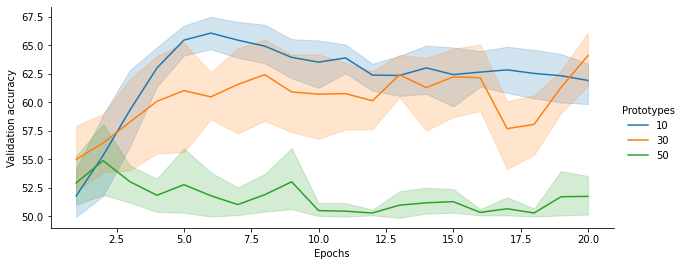

In [299]:
fig = sns.relplot(
    data = df_for_metrics_chart, kind = "line",
    x = "Epochs", y = "Validation accuracy", 
    hue = "Prototypes", 
    # style = "Group", 
    height=3.8, aspect = 2.3,
    facet_kws = dict(sharex = True, sharey=False)
)
fig.savefig(path_of_saving_images + 'protorynet_LOGO.png')
fig.savefig(path_of_saving_images + 'protorynet_LOGO.pdf')

## Results for specific examples. 

Here we use the best performing model (one of the ones that uses 10 prototypes).
We picked some text samples from the test set. 

* Sample 2361: the model was very confident about classifying it as man. The score was 0.124327704. Nevertheless, this character was a woman. 
* Sample 1152: the model was very confident about classifying it as man and it was correctly classified. The score was 0.12643227.
* Samples 1652, 73, 329 and 499: the model was uncertain about them. The scores were respectively 0.47313863, 0.480969042, 0.510326028 and 0.514082253.
* Sample 394: the model was very confident about classifying it as woman. The score was 0.920945883. Nevertheless, this character was a man.
* Sample 1788: the model was very confident about classifying it as woman and it was correctly classified. The score was 0.973135948.


In ```choosen_dialogues_results.csv``` and ```choosen_dialogues_results.xlsx```, we can see the predictions for those samples using the best performing model of 10 prototypes, sentences in the samples, the prototypes associated to each sentence, and the score of each prototype.

In [198]:
chosen_dialogues_idx = [2361, 1152, 1652, 73, 329, 499, 394, 1788]
chosen_dialogues = x_test[chosen_dialogues_idx]

In [37]:
# Get results in specific dialogues
for model_name in models:
    results = eval_examples(chosen_dialogues, 
                            x_train, 
                            model_directory = 'results/protorynet_models/', 
                            model_name = model_name, 
                            results_path= 'results/protorynet_models/')

[db] model.input =  KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.string, name='input_15'), name='input_15', description="created by layer 'input_15'")
[db] protoLayerName =  proto_layer
[db] protoLayer =  <protoryNet.ProtoryNet.createModel.<locals>.prototypeLayer object at 0x7fbc32a86e90>
[db] protoLayer.output =  (<KerasTensor: shape=(1, None, 10) dtype=float32 (created by layer 'proto_layer')>, <KerasTensor: shape=(10, 512) dtype=float32 (created by layer 'proto_layer')>)
[db] distanceLayer.output =  KerasTensor(type_spec=TensorSpec(shape=(1, None, 10), dtype=tf.float32, name=None), name='distance_layer/PartitionedCall:0', description="created by layer 'distance_layer'")
Model: "custom_model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None,)]                 0         
                                                                 
 keras_layer_13 (

                                                                 
 lstm_15 (LSTM)              [(1, None, 128),          71168     
                              (1, 128),                          
                              (1, 128)]                          
                                                                 
 tf.__operators__.getitem_15  (1, 128)                 0         
  (SlicingOpLambda)                                              
                                                                 
 dense_15 (Dense)            (1, 1)                    129       
                                                                 
 tf.compat.v1.squeeze_15 (TF  (1,)                     0         
 OpLambda)                                                       
                                                                 
 model_60 (Functional)       ((1, None, 10),           256802944 
                              (10, 512))                         
          

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None,)]                 0         
                                                                 
 keras_layer_18 (KerasLayer)  (None, 512)              256797824 
                                                                 
 tf.expand_dims_18 (TFOpLamb  (1, None, 512)           0         
 da)                                                             
                                                                 
 proto_layer (prototypeLayer  ((1, None, 30),          15360     
 )                            (30, 512))                         
                                                                 
 distance_layer (distanceLay  (1, None, 30)            0         
 er)                                                             
                                                                 
 lstm_18 (

 OpLambda)                                                       
                                                                 
 model_80 (Functional)       ((1, None, 50),           256823424 
                              (50, 512))                         
                                                                 
 model_81 (Functional)       (1, None, 50)             256823424 
                                                                 
Total params: 256,915,201
Trainable params: 256,915,201
Non-trainable params: 0
_________________________________________________________________
Embedding time (minutes): 0.6971542080243428
Prototypes time (minutes): 2.360746204853058
Preds and prototypes for sentences time (minutes): 0.9126195987065633
[db] model.input =  KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.string, name='input_23'), name='input_23', description="created by layer 'input_23'")
[db] protoLayerName =  proto_layer
[db] protoLayer =  <protoryNet.Pro

In [264]:
# Load the results for the best performing model only
results = pickle.load(open(results_path + 'eval_ex' + 'cornell_prepro_characters_70train_20val_10test__20epochs__10prototypes__randomtype_init__30000sample_size_sentences__81init_prototypes_seed' + '.pickle', 'rb'))

# Split the choosen dialogues in sentences and put it each sentence in a dataframe with the matching prototype
df_example = {}
chosen_dialogues_splitted = myfunctions.split_sentences(chosen_dialogues)
gender = cornell_prepro_characters['gender'][chosen_dialogues_idx]
number_sentences = [len(i) for i in chosen_dialogues_splitted]
df_example['gender'] = np.repeat(gender, number_sentences)
df_example['prediction'] = np.repeat(results['predictions'], number_sentences)
df_example['prototypes'] = np.concatenate([np.array(i) for i in results['prototypes_matching']])
df_example['prototypes_score'] = np.concatenate([np.array(i) for i in results['prototypes_matching_pred_scores']])
df_example['sentences'] = np.concatenate([np.array(i) for i in chosen_dialogues_splitted ])

# In the csv it is easier to visualize how each sentence was matched to a prototype.
pd.DataFrame(df_example).to_csv(results_path + 'choosen_dialogues_results.csv')